# Data Ingestion and Preparation Using a Feature Store


In the previous section, you created ML features manually on a small scale (using a notebook with Pandas). However, when deploying ML to production, the process of ingesting, transforming, storing, versioning, and serving data should be automated and run at scale. Organizations use dedicated data and ML engineering teams to productize and scale the data pipelines, which requires more time and resources and can lead to errors and inconsistencies. Furthermore, when the application works with real-time transactional data, the data processing is based on streaming technologies, forcing even more complex and duplicate implementations.

Feature stores enable reuse and collaboration, where the same features can be engineered once and used in different applications. In addition, features can be updated and refreshed constantly, resulting in more accurate and up-to-date models and a simplified model retraining process.

Some feature stores (like MLRun and Tecton) automate the development and deployment of the feature generation (transformation) data pipelines. This section will show you how to use MLRun to easily build feature engineering pipelines and deploy them as batch or real-time scenarios.

Feature stores define groups of features (feature sets) that are ingested and transformed together from the same online or offline source. In the example, you will define three feature sets (credit transactions, user activities, and labels), each with its source, transformations, and target store definitions. Feature set definitions can be saved and later deployed in an application context, reading from offline (for example, object storage or a database) or online (for example, a Kafka stream or an HTTP endpoint) sources.

After the features are stored and versioned in the feature store, they can be combined into feature vectors that the model training, serving, or monitoring applications will use.

In MLRun, all the assets and resources (functions, workflows, data, features, models, and so on) are grouped into projects. Projects can be deployed as a whole, have access control and policies, and are usually mapped to a GIT repository for simple deployment and versioning. The first step in the notebook is to create a new project or load an existing project from the version control or database

In [1]:
import mlrun
import os 

project = mlrun.load_project(
    name="fraud-demo",
    context="./",
    user_project=True,
    )

In [12]:
## Get redis secret
# Create a new MLRun function
fn = mlrun.code_to_function(name="get_redis_secret",
                            kind="job",
                            filename="src/secret_handler.py",  # Load the function from the file
                            image="mlrun/mlrun")  # Use an appropriate MLRun image

# Run the function with the handler name passed as a string, and pass the secrets
run = fn.run(handler="get_redis_secret", secrets={"k8s": ["redis"]})

> 2024-10-21 09:14:29,175 [warning] it is recommended to use k8s secret (specify secret_name), specifying the aws_access_key/aws_secret_key directly is unsafe
> 2024-10-21 09:14:29,193 [info] Storing function: {'name': 'get-redis-secret-get-redis-secret', 'uid': 'b1c7e97c7642455183e01b16357d409d', 'db': 'http://mlrun-api:8080'}
> 2024-10-21 09:14:29,290 [info] Job is running in the background, pod: get-redis-secret-get-redis-secret-xs7jr
> 2024-10-21 09:14:30,969 [info] To track results use the CLI: {'info_cmd': 'mlrun get run b1c7e97c7642455183e01b16357d409d -p fraud-demo-jovyan', 'logs_cmd': 'mlrun logs b1c7e97c7642455183e01b16357d409d -p fraud-demo-jovyan'}
> 2024-10-21 09:14:30,969 [info] Run execution finished: {'status': 'completed', 'name': 'get-redis-secret-get-redis-secret'}



project,uid,iter,start,state,name,labels,inputs,parameters,results
fraud-demo-jovyan,...357d409d,0,Oct 21 09:14:30,completed,get-redis-secret-get-redis-secret,kind=jobowner=jovyanmlrun/client_version=1.6.4mlrun/client_python_version=3.9.13host=get-redis-secret-get-redis-secret-xs7jr,,,return=b8gtDXuxec


> 2024-10-21 09:14:36,334 [info] Run execution finished: {'status': 'completed', 'name': 'get-redis-secret-get-redis-secret'}


In [13]:
redis_password = run.output("return")

In [40]:
# When running on community edition, redis instance is needed.
from mlrun.datastore.datastore_profile import DatastoreProfileRedis, register_temporary_client_datastore_profile

if mlrun.mlconf.is_ce_mode():
    redis_uri = "redis://" + os.environ.get('REDIS_MASTER_SERVICE_HOST', "") + ":" + os.environ.get('REDIS_MASTER_SERVICE_PORT', "") # e.g. redis://100.172.111.198:6379
    redis_user = os.environ.get("REDIS_USER", "")
    os.environ['REDIS_USER'] = redis_user
    os.environ['REDIS_PASSWORD'] = redis_password
    kafka_uri = os.environ.get('KAFKA_SERVICE_HOST', None)

    prefix = f's3://mlrun/{project.name}'

    project.set_secrets({"REDIS_USER": redis_user,
                         "REDIS_PASSWORD": redis_password})
    project.save()

    profile = DatastoreProfileRedis(name="profile-name",
                                    endpoint_url=redis_uri,
                                    username=redis_user,
                                    password=redis_password)

    register_temporary_client_datastore_profile(profile)
    project.register_datastore_profile(profile)
else:
    redis_uri = None
    kafka_uri = None
    prefix = f'v3io:///projects/{project.name}'

In [44]:
profile

DatastoreProfileRedis(type='redis', name='profile-name', endpoint_url='redis://10.43.185.251:6379', username='', password='b8gtDXuxec')

## Building the Credit Transactions Data Pipeline (Feature Set)

The following part generates and aggregates new features from the credit transactions dataset and stores them in offline and online forms for training and real-time serving. First, define the feature set, its main entity (index), timestamp, and so on. Next, define the set of feature transformations (mappings, encoding, aggregations, custom operators, and so on). And finally, specify how or where to store the results (online and offline data stores) or use the system defaults.

In [2]:
import pandas as pd
from src.date_adjust import adjust_data_timespan

# Fetch the transactions dataset from the server
transactions_data = pd.read_csv(mlrun.get_sample_path("data/fraud-demo-mlrun-fs-docs/data.csv"), parse_dates=['timestamp'])

# use only first 10k
transactions_data = transactions_data.sort_values(by='source', axis=0)[:10000]

# Adjust the samples timestamp for the past 2 days
transactions_data = adjust_data_timespan(transactions_data, new_period='2d')

# Sorting after adjusting timestamps
transactions_data = transactions_data.sort_values(by='timestamp', axis=0)

# Preview
transactions_data.head(3)

,step,age,gender,zipcodeOri,zipMerchant,category,amount,fraud,timestamp,source,target,device
274633,91,5,F,28007,28007,es_transportation,26.92,0,2024-10-19 15:47:01.162061000,C1022153336,M1823072687,33832bb8607545df97632a7ab02d69c4
286902,94,2,M,28007,28007,es_transportation,48.22,0,2024-10-19 15:47:19.455686913,C1006176917,M348934600,fadd829c49e74ffa86c8da3be75ada53
416998,131,3,M,28007,28007,es_transportation,17.56,0,2024-10-19 15:47:24.562856939,C1010936270,M348934600,58d0422a50bc40c89d2b4977b2f1beea


### Defining the transactions feature set

In [3]:
# Import MLRun's Feature Store
import mlrun.feature_store as fstore
from mlrun.feature_store.steps import OneHotEncoder, MapValues, DateExtractor

In [4]:
# Define the transactions FeatureSet
transaction_set = fstore.FeatureSet("transactions", 
                                 entities=[fstore.Entity("source")], 
                                 timestamp_key='timestamp', 
                                 description="transactions feature set")

The MLRun feature set pipeline is implemented using a graph (DAG) of multiple
connected steps, where the `.to()` operation links one step to the next in line. 
You can visually inspect the generated pipeline using `.plot()`, and test it with sample data to verify it produces the expected results using .preview().

In [5]:
# Define and add value mapping
main_categories = ["es_transportation", "es_health", "es_otherservices",
       "es_food", "es_hotelservices", "es_barsandrestaurants",
       "es_tech", "es_sportsandtoys", "es_wellnessandbeauty",
       "es_hyper", "es_fashion", "es_home", "es_contents",
       "es_travel", "es_leisure"]

# One Hot Encode the newly defined mappings
one_hot_encoder_mapping = {'category': main_categories,
                           'gender': list(transactions_data.gender.unique())}

# Define the graph steps
transaction_set.graph\
    .to(DateExtractor(parts = ['hour', 'day_of_week'], timestamp_col = 'timestamp'))\
    .to(MapValues(mapping={'age': {'U': '0'}}, with_original_features=True))\
    .to(OneHotEncoder(mapping=one_hot_encoder_mapping))


# Add aggregations for 2, 12, and 24 hour time windows
transaction_set.add_aggregation(name='amount',
                                column='amount',
                                operations=['avg','sum', 'count','max'],
                                windows=['2h', '12h', '24h'],
                                period='1h')


# Add the category aggregations over a 14 day window
for category in main_categories:
    transaction_set.add_aggregation(name=category,column=f'category_{category}',
                                    operations=['sum'], windows=['14d'], period='1d')

# Add default (offline-parquet & online-nosql) targets
transaction_set.set_targets()

### Visualize and test the transactions feature set

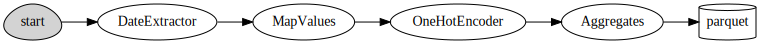

In [6]:
# Plot the pipeline so you can see the different steps
transaction_set.plot(rankdir="LR", with_targets=True)


In [7]:
# Preview the resulting features from ingesting sample data (transactions_data)
transaction_set.preview(transactions_data)

,amount_sum_2h,amount_sum_12h,amount_sum_24h,amount_count_2h,amount_count_12h,amount_count_24h,amount_max_2h,amount_max_12h,amount_max_24h,amount_avg_2h,...,category_es_contents,category_es_travel,category_es_leisure,amount,fraud,timestamp,target,device,timestamp_hour,timestamp_day_of_week
source,,,,,,,,,,,,,,,,,,,,,
C1022153336,26.92,26.92,26.92,1.0,1.0,1.0,26.92,26.92,26.92,26.920000,...,0,0,0,26.92,0,2024-10-19 15:47:01.162061000,M1823072687,33832bb8607545df97632a7ab02d69c4,15,5
C1006176917,48.22,48.22,48.22,1.0,1.0,1.0,48.22,48.22,48.22,48.220000,...,0,0,0,48.22,0,2024-10-19 15:47:19.455686913,M348934600,fadd829c49e74ffa86c8da3be75ada53,15,5
C1010936270,17.56,17.56,17.56,1.0,1.0,1.0,17.56,17.56,17.56,17.560000,...,0,0,0,17.56,0,2024-10-19 15:47:24.562856939,M348934600,58d0422a50bc40c89d2b4977b2f1beea,15,5
C1033736586,4.50,4.50,4.50,1.0,1.0,1.0,4.50,4.50,4.50,4.500000,...,0,0,0,4.50,0,2024-10-19 15:47:36.855608118,M1823072687,30b269ae55984e5584f1dd5f642ac1a3,15,5
C1019071188,1.83,1.83,1.83,1.0,1.0,1.0,1.83,1.83,1.83,1.830000,...,0,0,0,1.83,0,2024-10-19 15:48:10.744690001,M348934600,97bee3503a984f59aa6139b59f933c0b,15,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C1032715879,118.62,805.10,1730.23,4.0,27.0,58.0,54.55,70.47,85.97,29.655000,...,0,0,0,26.00,0,2024-10-21 15:45:59.075914884,M348934600,dcd0943b34254126a2d79d3ac652f268,15,0
C1005806982,31.14,150.64,330.61,1.0,2.0,5.0,31.14,119.50,119.50,31.140000,...,0,0,0,31.14,0,2024-10-21 15:46:03.439848022,M1741626453,c186fb979a77422fa06296c3ff2813f6,15,0
C1018783569,397.43,1076.37,1968.00,6.0,25.0,59.0,218.48,218.48,218.48,66.238333,...,0,0,0,218.48,0,2024-10-21 15:46:30.822371602,M1053599405,73bdcf0627aa4cc5b882f397cf0d1177,15,0


After performing the ingestion process, you can see all of the different features that were created with the help of the UI, asshown in the image below.

![Features Catalog - fraud prevention](images/features-catalog-transaction.png)

## Building the User Events Data Pipeline (Feature Set)

The events data pipeline is simpler and has a single transformation for encoding the event category (using one-hot encoding). The next part demonstrates defining the
user events feature set, adding the transformation, and testing the feature set with sample data.

### Define, visualize and test the events feature set

In [8]:
# Fetch the user_events dataset from the server
user_events_data = pd.read_csv('https://s3.wasabisys.com/iguazio/data/fraud-demo-mlrun-fs-docs/events.csv', 
                               index_col=0, quotechar="\'", parse_dates=['timestamp'])

# Adjust to the last 2 days to see the latest aggregations in the online feature vectors
user_events_data = adjust_data_timespan(user_events_data, new_period='2d')

# Preview
user_events_data.head(3)

,source,event,timestamp
45553,C137986193,password_change,2024-10-19 15:48:46.588476000
24134,C1940951230,details_change,2024-10-19 15:48:47.636658091
64444,C247537602,login,2024-10-19 15:48:49.291441103


In [9]:
user_events_set = fstore.FeatureSet("events",
                           entities=[fstore.Entity("source")],
                           timestamp_key='timestamp', 
                           description="user events feature set")

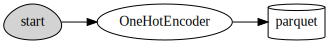

In [10]:
# Define and add value mapping
events_mapping = {'event': list(user_events_data.event.unique())}

# One Hot Encode
user_events_set.graph.to(OneHotEncoder(mapping=events_mapping))

# Add default (offline-parquet & online-nosql) targets
user_events_set.set_targets()

# Plot the pipeline so you can see the different steps
user_events_set.plot(rankdir="LR", with_targets=True)

In [11]:
user_events_set.preview(user_events_data)

,event_password_change,event_details_change,event_login,timestamp
source,,,,
C137986193,1,0,0,2024-10-19 15:48:46.588476000
C1940951230,0,1,0,2024-10-19 15:48:47.636658091
C247537602,0,0,1,2024-10-19 15:48:49.291441103
C470079617,1,0,0,2024-10-19 15:48:50.581890428
C1142118359,0,0,1,2024-10-19 15:48:51.372182830
...,...,...,...,...
C71938921,0,0,1,2024-10-21 15:48:37.138025776
C1790426542,1,0,0,2024-10-21 15:48:42.209229974
C662187574,0,0,1,2024-10-21 15:48:43.629884178


## Building The Target Labels Data Pipeline (Feature Set)

The third feature set defines how to create the target labels. Target labels are only used in training, so they are only stored in the offline store (during serving, the target value is predicted by the model). The basic pandas engine is used, since real-time processing is unnecessary, and the processing is simple and stateless.

### Define, visualize, and test the events feature set

In [12]:
def create_labels(df):
    labels = df[['fraud','timestamp']].copy()
    labels = labels.rename(columns={"fraud": "label"})
    labels['timestamp'] = labels['timestamp'].astype("datetime64[ms]")
    labels['label'] = labels['label'].astype(int)
    return labels

In [14]:
    prefix = f's3://mlrun/{project.name}'


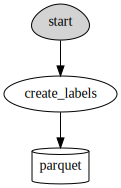

In [15]:
from mlrun.datastore import ParquetTarget
import os

# Define the "labels" feature set, use "pandas" processing engine
labels_set = fstore.FeatureSet("labels", 
                           entities=[fstore.Entity("source")], 
                           timestamp_key='timestamp',
                           description="training labels",
                           engine="pandas")

labels_set.graph.to(name="create_labels", handler=create_labels)


# specify only Parquet (offline) target since its not used for real-time
target = ParquetTarget(path=os.path.join(prefix, 'labels.parquet'))
labels_set.set_targets([target], with_defaults=False)

# Visualize the feature set
labels_set.plot(with_targets=True)

In [16]:
labels_set.preview(transactions_data)

,label,timestamp
source,,
C1022153336,0,2024-10-19 15:47:01.162
C1006176917,0,2024-10-19 15:47:19.455
C1010936270,0,2024-10-19 15:47:24.562
C1033736586,0,2024-10-19 15:47:36.855
C1019071188,0,2024-10-19 15:48:10.744
...,...,...
C1032715879,0,2024-10-21 15:45:59.075
C1005806982,0,2024-10-21 15:46:03.439
C1018783569,0,2024-10-21 15:46:30.822


## Ingesting Data Into the Feature Store

Data must be ingested into the feature store before it can be used in training or serving. There are three ways to ingest data:

1. Direct ingestion - ingest the data directly from the client/notebook (interactively) 
2. Batch/scheduled ingestion - create a service/job whithat that ingests data from the source (e.g. file, DB, ..)
3. Real-time/Streaming ingestion - create an online service that accepts real-time events (from a stream, http, etc.) and push them into the feature store

Direct and batch ingestion are achieved using the `ingest()` method, while real-time ingestion is done using the `deploy_ingestion_service()` method. Both methods are demonstrated in the following sections. The direct ingestion is great for development and testing while the real-time ingestion is mainly used in production.

### Batch data ingestion (for tests and training)

To run training or test the serving you need to ingest and transform the input datasets and store the results in the feature store. The simplest way is to use the `ingest()` method and specify the feature-set and the source (Dataframe, file, etc.).

You can specify the desired target if you want to overwrite the default behavior. For example, set `targets=[ParquetTarget()]` to specify that the data will only be written to parquet files and will not be written to the NoSQL DB (meaning you cannot run real-time serving).

The `ingest()` method has many other args/options, see the [documentation](https://docs.mlrun.org/en/stable/data-prep/ingest-data-fs.html?highlight=ingest) for details.


In [17]:
# Ingest your transactions dataset through your defined pipeline
transactions_df = fstore.ingest(transaction_set, transactions_data, 
                 infer_options=fstore.InferOptions.default())

# Ingestion of your newly created events feature set
events_df = fstore.ingest(user_events_set, user_events_data)

# Ingest the labels feature set
labels_df = fstore.ingest(labels_set, transactions_data)

### Transactions - Real-time data ingestion (for Production)

When dealing with real-time aggregation, it's important to be able to update these aggregations in real-time.
For this purpose, you create live serving functions that update the online feature store of the `transactions` 
FeatureSet and `Events` FeatureSet.

Using MLRun's `serving` runtime, create a `nuclio` function loaded with your feature set's computational graph definition
and an `HttpSource` to define the HTTP trigger.

Notice that the implementation below does not require any rewrite of the pipeline logic.

### Transactions - Deploy real-time feature set ingestion pipeline

In [20]:
kafka_uri = f"{os.environ.get('KAFKA_SERVICE_HOST', None)}:{os.environ.get('KAFKA_SERVICE_PORT')}"

In [22]:
# Create kafka stream and transactions push API endpoint
transaction_stream = f'kafka://{kafka_uri}?topic=transactions'
transaction_pusher = mlrun.datastore.get_stream_pusher(transaction_stream)

In [25]:
# Define the source stream trigger (use v3io streams)
# define the `key` and `time` fields (extracted from the Json message).
source = mlrun.datastore.sources.KafkaSource(name="kakfa-source", brokers=kafka_uri, topics="transactions")

# Deploy the transactions feature set's ingestion service over a real-time (Nuclio) serverless function
# you can use the run_config parameter to pass function/service specific configuration
transaction_set_endpoint = transaction_set.deploy_ingestion_service(source=source)

[nuclio] 2024-10-21 17:29:52,844 workerAllocationMode was automatically set to 'static' because explicitAckMode is enabled
> 2024-10-21 17:29:52,845 [warning] it is recommended to use k8s secret (specify secret_name), specifying the aws_access_key/aws_secret_key directly is unsafe
> 2024-10-21 17:29:52,846 [info] Starting remote function deploy
2024-10-21 17:29:52  (info) Deploying function
2024-10-21 17:29:52  (info) Building
2024-10-21 17:29:52  (info) Staging files and preparing base images
2024-10-21 17:29:52  (warn) Using user provided base image, runtime interpreter version is provided by the base image
2024-10-21 17:29:52  (info) Building processor image
2024-10-21 17:33:28  (info) Build complete
2024-10-21 17:33:40  (info) Function deploy complete
> 2024-10-21 17:33:43,704 [info] Successfully deployed function: {'internal_invocation_urls': ['nuclio-fraud-demo-jovyan-transactions-ingest.mlrun.svc.cluster.local:8080'], 'external_invocation_urls': ['localhost:30637']}


### Transactions - Test the feature set HTTP endpoint

By defining your `transactions` feature set you can now use MLRun and Storey to deploy it as a live endpoint, ready to ingest new data!

Using MLRun's `serving` runtime, create a nuclio function loaded with your feature set's computational graph definition 
and an `HttpSource` to define the HTTP trigger.

In [26]:
import requests
import json

# Select a sample from the dataset and serialize it to JSON
transaction_sample = json.loads(transactions_data.sample(1).to_json(orient='records'))[0]
transaction_sample['timestamp'] = str(pd.Timestamp.now())
transaction_sample

{'step': 123,
 'age': '5',
 'gender': 'M',
 'zipcodeOri': 28007,
 'zipMerchant': 28007,
 'category': 'es_transportation',
 'amount': 23.34,
 'fraud': 0,
 'timestamp': '2024-10-21 17:33:50.868531',
 'source': 'C1035581047',
 'target': 'M1823072687',
 'device': '8402d5f0c55a4b02bec8f517082c88c6'}

In [30]:
transaction_set_endpoint[0]

'http://localhost:30637'

##### transaction_set_endpoint[0] uses localhost. Should change to external IP and nodeport or internal service 

In [37]:
# Post the sample to the ingestion endpoint
requests.post("http://100.98.222.55:30637", json=transaction_sample).text

'{"id": "0e504aa2-2b20-4665-9f7c-42d26a512e8d"}'

### User events - deploy the feature set live endpoint
Deploy the events feature set's ingestion service using the feature set and all the previously defined resources.

In [38]:
# Create kafka stream and transactions push API endpoint
events_stream = f'kafka://{kafka_uri}?topic=events'

    
events_pusher = mlrun.datastore.get_stream_pusher(events_stream)

In [40]:
# Define the source stream trigger (use v3io streams)
# define the `key` and `time` fields (extracted from the Json message).
source = mlrun.datastore.sources.KafkaSource(name="kakfa-source", brokers=kafka_uri, topics="events")

# Deploy the transactions feature set's ingestion service over a real-time (Nuclio) serverless function
# you can use the run_config parameter to pass function/service specific configuration
events_set_endpoint = user_events_set.deploy_ingestion_service(source=source)

[nuclio] 2024-10-21 17:49:50,414 workerAllocationMode was automatically set to 'static' because explicitAckMode is enabled
> 2024-10-21 17:49:50,415 [warning] it is recommended to use k8s secret (specify secret_name), specifying the aws_access_key/aws_secret_key directly is unsafe
> 2024-10-21 17:49:50,416 [info] Starting remote function deploy
2024-10-21 17:49:50  (info) Deploying function
2024-10-21 17:49:50  (info) Building
2024-10-21 17:49:50  (info) Staging files and preparing base images
2024-10-21 17:49:50  (warn) Using user provided base image, runtime interpreter version is provided by the base image
2024-10-21 17:49:50  (info) Building processor image
2024-10-21 17:53:45  (info) Build complete
2024-10-21 17:53:57  (info) Function deploy complete
> 2024-10-21 17:54:01,674 [info] Successfully deployed function: {'internal_invocation_urls': ['nuclio-fraud-demo-jovyan-events-ingest.mlrun.svc.cluster.local:8080'], 'external_invocation_urls': ['localhost:30967']}


### User Events - Test the feature set HTTP endpoint

In [41]:
# Select a sample from the events dataset and serialize it to JSON
user_events_sample = json.loads(user_events_data.sample(1).to_json(orient='records'))[0]
user_events_sample['timestamp'] = str(pd.Timestamp.now())
user_events_sample

{'source': 'C1348957967',
 'event': 'password_change',
 'timestamp': '2024-10-21 17:54:01.701222'}

In [42]:
events_set_endpoint[0]

'http://localhost:30967'

In [43]:
# Post the sample to the ingestion endpoint
requests.post("http://100.98.222.55:30967", json=user_events_sample).text

'{"id": "3feef6b9-2be7-4290-aea6-f1c1253d27d5"}'

## Done!

You've completed the third part - the data-ingestion with the feature store.
Proceed to [Part 4](04-train-test-pipeline.ipynb) to learn how to train an ML model using the feature store data.